USING A DATA SET WITH RF REDUCED DIMENSIONS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**FEATURE ENGINEERING AND MODEL CONFIGURATION**

In [10]:
# --- Essential Installs ---
!pip install --upgrade darts pytorch_lightning # Run if darts not installed/needs update
!pip install scikit-learn # Needed for scalers

import os
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from darts import TimeSeries
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Keep scalers
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pickle

# --- Mount Google Drive (if using Colab) ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
    # Define base path where the RFFS script SAVED its output
    gdrive_fs_output_path = "/content/drive/MyDrive/Feature_Selection_Output" # <--- PATH WHERE RFFS RESULTS ARE SAVED
except ImportError:
    print("Not running in Colab or Drive mounting failed.")
    gdrive_fs_output_path = "./Feature_Selection_Output" # <--- LOCAL PATH WHERE RFFS RESULTS ARE SAVED

# --- Configuration ---
gdrive_path = '/content/drive/MyDrive/DORC_tft_REF_training_RFFS' # Example Google Drive path for THIS TFT run's output
os.makedirs(gdrive_path, exist_ok=True)
model_name = "DORC_TFT_FORCASTOR_v5_RFFS_Reduced" # Model name for RFFS-reduced run
work_dir_model = os.path.join(gdrive_path, model_name)
os.makedirs(work_dir_model, exist_ok=True) # Ensure model directory exists

# --- Model Hyperparameters (Start with reduced size, might need adjustment based on n_features selected) ---
input_chunk_length = 20 # Keeping the adjusted length from previous run
output_chunk_length = 7
n_epochs = 70 # Keep slightly increased epochs
batch_size = 32
learning_rate = 0.0005
hidden_size = 16 # Keep reduced size as a start
attention_head_size = 2
dropout = 0.1
hidden_continuous_size = 8
random_seed = 42

# --- Seed ---
pl.seed_everything(random_seed, workers=True)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# --- Helper Function to Load Lists ---
def load_list_from_file(directory, filename):
    """Loads a list of strings from a text file (one item per line)."""
    path = os.path.join(directory, filename)
    try:
        with open(path, 'r') as f:
            items = [line.strip() for line in f if line.strip()]
        return items
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        raise
    except Exception as e:
        print(f"Error reading list from {path}: {e}")
        raise

# --- Step 1: Load RFFS Reduced Data from Saved Files ---
print("--- Step 1: Loading RFFS-Reduced Data from Files ---")

# Define filenames used by the RFFS saving script
train_data_filename = "/content/drive/MyDrive/Feature_Selection_Output/train_data_rf_selected.csv"
val_data_filename = "/content/drive/MyDrive/Feature_Selection_Output/val_data_rf_selected.csv"
target_cols_filename = "/content/drive/MyDrive/Feature_Selection_Output/target_cols.txt"
future_cols_filename = "/content/drive/MyDrive/Feature_Selection_Output/future_covariate_cols.txt"
selected_past_cols_filename = "/content/drive/MyDrive/Feature_Selection_Output/past_covariates_selected_rf.txt" # List of selected original feature names

try:
    print(f"Loading data and lists from directory: {gdrive_fs_output_path}")

    # --- Load DataFrames ---
    train_df_path = os.path.join(gdrive_fs_output_path, train_data_filename)
    val_df_path = os.path.join(gdrive_fs_output_path, val_data_filename)

    print(f"Loading training data from: {train_df_path}")
    train_df = pd.read_csv(train_df_path, index_col='date', parse_dates=True)

    print(f"Loading validation data from: {val_df_path}")
    val_df = pd.read_csv(val_df_path, index_col='date', parse_dates=True)

    # --- Load Column Lists ---
    print("Loading column lists...")
    target_cols = load_list_from_file(gdrive_fs_output_path, target_cols_filename)
    future_covariate_cols = load_list_from_file(gdrive_fs_output_path, future_cols_filename)
    # CRITICAL: Load the RFFS selected column list into the variable used by the rest of the script
    past_covariate_cols = load_list_from_file(gdrive_fs_output_path, selected_past_cols_filename)

    print("Successfully loaded RFFS results from files.")
    print(f"Loaded train_df shape: {train_df.shape}")
    print(f"Loaded val_df shape: {val_df.shape}")
    print(f"Using {len(target_cols)} target columns.")
    print(f"Using {len(future_covariate_cols)} future covariate columns.")
    print(f"Using {len(past_covariate_cols)} RFFS selected past covariate columns (e.g., {past_covariate_cols[:3]}...).")

except FileNotFoundError as fe:
     print(f"Error loading saved RFFS results: {fe}")
     print(f"Please ensure the directory '{gdrive_fs_output_path}' exists and contains the required files:")
     print(f"  - {train_data_filename}")
     print(f"  - {val_data_filename}")
     print(f"  - {target_cols_filename}")
     print(f"  - {future_cols_filename}")
     print(f"  - {selected_past_cols_filename}")
     raise fe
except Exception as e:
     print(f"An unexpected error occurred during loading: {e}")
     raise e


# --- Verify Index Types ---
if not isinstance(train_df.index, pd.DatetimeIndex):
     print("Error: Loaded train_df index is not DatetimeIndex."); exit()
if not isinstance(val_df.index, pd.DatetimeIndex):
     print("Error: Loaded val_df index is not DatetimeIndex."); exit()


# --- Step 2: Critical Length Check (using loaded pre-split data) ---
print("\n--- Step 2: Checking Data Lengths ---")
min_required_train_length = input_chunk_length + output_chunk_length
min_required_val_length = input_chunk_length + output_chunk_length
print(f"Required minimum series length for one sample: {min_required_train_length}")
print(f"Actual training data length: {len(train_df)}")
print(f"Actual validation data length: {len(val_df)}")
if len(train_df) < min_required_train_length: raise ValueError(f"Training data length ({len(train_df)}) insufficient.")
if len(val_df) < min_required_val_length: print(f"Warning: Validation data length ({len(val_df)}) insufficient.")


# --- Step 3: Data Scaling (using pre-split data and RFFS columns) ---
print("\n--- Step 3: Scaling Data ---")

# Target Scaler (Remains the same)
target_scaler = Scaler(MinMaxScaler()); print("Scaling Targets...")
if not all(col in train_df.columns for col in target_cols): raise ValueError("Missing target columns in loaded train_df")
train_target_ts = TimeSeries.from_dataframe(train_df, value_cols=target_cols, freq='D')
train_target_scaled = target_scaler.fit_transform(train_target_ts)
print(f"Train target TimeSeries length: {len(train_target_scaled)}")
scaler_save_path = os.path.join(work_dir_model, "target_scaler_rffs.pkl") # Adjusted name
print(f"Saving target scaler to: {scaler_save_path}")
with open(scaler_save_path, "wb") as f: pickle.dump(target_scaler, f)
if not all(col in val_df.columns for col in target_cols): raise ValueError("Missing target columns in loaded val_df")
val_target_ts = TimeSeries.from_dataframe(val_df, value_cols=target_cols, freq='D')
val_target_scaled = target_scaler.transform(val_target_ts)
print(f"Validation target TimeSeries length: {len(val_target_scaled)}")

# Past Covariates Scaler (Now scaling the SELECTED ORIGINAL features)
if past_covariate_cols:
    print(f"Scaling {len(past_covariate_cols)} RFFS selected past covariates...")
    # StandardScaler is generally recommended for original features too
    past_cov_scaler = Scaler(StandardScaler())
    if not all(col in train_df.columns for col in past_covariate_cols):
        missing_cols = [col for col in past_covariate_cols if col not in train_df.columns]
        raise ValueError(f"Missing RFFS past covariate columns in loaded train_df: {missing_cols}")
    # Fit scaler on training data for these selected columns ONLY
    train_past_cov_ts = TimeSeries.from_dataframe(train_df, value_cols=past_covariate_cols, freq='D')
    train_past_cov_scaled = past_cov_scaler.fit_transform(train_past_cov_ts)
    print(f"Train past covariates (RFFS) TimeSeries length: {len(train_past_cov_scaled)}")
    scaler_save_path_past = os.path.join(work_dir_model, "past_cov_rffs_scaler.pkl") # Adjusted name
    print(f"Saving past covariate (RFFS) scaler to: {scaler_save_path_past}")
    with open(scaler_save_path_past, "wb") as f: pickle.dump(past_cov_scaler, f)

    # Transform validation data for these selected columns
    if not all(col in val_df.columns for col in past_covariate_cols):
        missing_cols = [col for col in past_covariate_cols if col not in val_df.columns]
        raise ValueError(f"Missing RFFS past covariate columns in loaded val_df: {missing_cols}")
    val_past_cov_ts = TimeSeries.from_dataframe(val_df, value_cols=past_covariate_cols, freq='D')
    val_past_cov_scaled = past_cov_scaler.transform(val_past_cov_ts)
    print(f"Validation past covariates (RFFS) TimeSeries length: {len(val_past_cov_scaled)}")
else:
    print("No past covariates (RFFS selected) identified. Skipping scaling.")
    train_past_cov_scaled, val_past_cov_scaled = None, None

# Future Covariates (NO SCALING - same as before)
if future_covariate_cols:
    print(f"Preparing {len(future_covariate_cols)} future covariates (no scaling)...")
    if not all(col in train_df.columns for col in future_covariate_cols): raise ValueError("Missing future columns in loaded train_df")
    train_fut_cov = TimeSeries.from_dataframe(train_df, value_cols=future_covariate_cols, freq='D')
    print(f"Train future covariates TimeSeries length: {len(train_fut_cov)}")
    if not all(col in val_df.columns for col in future_covariate_cols): raise ValueError("Missing future columns in loaded val_df")
    val_fut_cov = TimeSeries.from_dataframe(val_df, value_cols=future_covariate_cols, freq='D')
    print(f"Validation future covariates TimeSeries length: {len(val_fut_cov)}")
else:
    print("No future covariates identified.")
    train_fut_cov, val_fut_cov = None, None

print("Scaling/Preparation complete.")
print(f"Outputs will be saved to: {gdrive_path}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
--- Step 1: Loading RFFS-Reduced Data from Files ---
Loading data and lists from directory: /content/drive/MyDrive/Feature_Selection_Output
Loading training data from: /content/drive/MyDrive/Feature_Selection_Output/train_data_rf_selected.csv
Loading validation data from: /content/drive/MyDrive/Feature_Selection_Output/val_data_rf_selected.csv
Loading column lists...
Successfully loaded RFFS results from files.
Loaded train_df shape: (123, 67)
Loaded val_df shape: (31, 67)
Using 12 target columns.
Using 5 future covariate columns.
Using 50 RFFS selected past covariate columns (e.g., ['102FIC2804', '101TI2601', '101TI1902']...).

--- Step 2: Checking Data Lengths ---
Required minimum series length for one sample: 27
Actual training data length: 123
Actual validation data length: 31

--- Step 3: Scaling Data ---
Scaling Target

**MODEL TRAINING**

In [11]:
# Defining Darts TFT Model

# Define optimizing parameters
optimizer_kwargs = {"lr": learning_rate}

# Define PyTorch Lightning Trainer arguments
lr_scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau
pl_trainer_kwargs = {
    "accelerator": "auto",
    "gradient_clip_val": 0.1,
    "max_epochs": n_epochs,
    "callbacks": [
        EarlyStopping(monitor="val_loss", patience=15, mode="min", verbose=True),
        LearningRateMonitor(logging_interval="epoch"),
    ],
    # Enable checkpointing (Darts handles the default checkpoint callback)
    "enable_checkpointing": True,
}

# Defining the loss function
# Default quantiles: [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
# loss_fn = QuantileLoss()
likelihood=QuantileRegression() # using likelihood as alternative
# Model definition
model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=hidden_size,
    lstm_layers=1,
    num_attention_heads=attention_head_size,
    dropout=dropout,
    batch_size=batch_size,
    n_epochs=n_epochs,
    add_relative_index=False, # Darts TFT adds this automatically based on time_idx
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"lr": learning_rate},
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 5, "factor": 0.2},
    likelihood=QuantileRegression(),
    random_state=random_seed,
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name=model_name, # Use defined model_name
    work_dir=work_dir_model, # Use specific model directory
    save_checkpoints=True, # Explicitly save checkpoints
    force_reset=True,      # Start fresh if model exists
    log_tensorboard=True
)

print("\n--- Starting Model Training ---")
# Training
model.fit(
    series=train_target_scaled,
    past_covariates=train_past_cov_scaled,
    future_covariates=train_fut_cov,
    val_series=val_target_scaled,
    val_past_covariates=val_past_cov_scaled,
    val_future_covariates=val_fut_cov,
    verbose=True,
    # num_loader_workers=2 # Optional: Adjust based on system
)

print("\n--- Training Complete ---")
print(f"Model saved in: {work_dir_model}")


--- Starting Model Training ---


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 5.734


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.191 >= min_delta = 0.0. New best score: 5.543


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.221 >= min_delta = 0.0. New best score: 5.322


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.190 >= min_delta = 0.0. New best score: 5.132


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 4.929


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.235 >= min_delta = 0.0. New best score: 4.693


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 4.455


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.233 >= min_delta = 0.0. New best score: 4.222


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.235 >= min_delta = 0.0. New best score: 3.987


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.242 >= min_delta = 0.0. New best score: 3.745


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.248 >= min_delta = 0.0. New best score: 3.498


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 3.258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.236 >= min_delta = 0.0. New best score: 3.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 2.783


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.224 >= min_delta = 0.0. New best score: 2.559


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.203 >= min_delta = 0.0. New best score: 2.355


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 2.164


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: 1.988


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 1.833


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.137 >= min_delta = 0.0. New best score: 1.696


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 1.585


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.491


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 1.403


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.323


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.251


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.193


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.144


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.095


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.049


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.972


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.946


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.944


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.944


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 15 records. Best score: 0.944. Signaling Trainer to stop.



--- Training Complete ---
Model saved in: /content/drive/MyDrive/DORC_tft_REF_training_RFFS/DORC_TFT_FORCASTOR_v5_RFFS_Reduced


**RETRAINING ON SAME DATA WITH MORE STEPS**

IMPORTING AND LOADING MODEL AND ITS SCALARS

In [ ]:
import pickle

try:
    with open(os.path.join(gdrive_path, "target_scaler.pkl"), "rb") as f:
        target_scaler = pickle.load(f)
    # Loading past_cov_scaler if you used it
    if os.path.exists(os.path.join(gdrive_path, "past_cov_scaler.pkl")):
         with open(os.path.join(gdrive_path, "past_cov_scaler.pkl"), "rb") as f:
            past_cov_scaler = pickle.load(f)
    else:
        past_cov_scaler = None
    # Loading future covariate setup (e.g., encoder) if applicable
    print("Original scalers loaded.")
except FileNotFoundError:
    print("ERROR: Original scalers not found. Cannot proceed with retraining without them.")
    # Handle error
    exit()

ERROR: Original scalers not found. Cannot proceed with retraining without them.


MODEL LOADING

In [12]:
print(f"Loading model '{model_name}' from {work_dir_model}...")

try:
    # Load the best checkpoint saved by the trainer
    loaded_model = TFTModel.load_from_checkpoint(
        model_name=model_name,
        work_dir=gdrive_path,
        best=True  # Load the checkpoint marked as best by the monitor (e.g., lowest val_loss)
    )
    print("Model loaded successfully.")
    # The loaded model retains its architecture, trained weights, optimizer state, etc.

except FileNotFoundError:
    print(f"ERROR: Checkpoint for model '{model_name}' not found in {work_dir_model}.")
    # Handle error
    exit()
except Exception as e:
    print(f"ERROR: Failed to load checkpoint. {e}")
    # Handle error
    exit()

Loading model 'DORC_TFT_FORCASTOR_v5_RFFS_Reduced' from /content/drive/MyDrive/DORC_tft_REF_training_RFFS/DORC_TFT_FORCASTOR_v5_RFFS_Reduced...
Model loaded successfully.


RECONFIGURATION AND RETRAINING

In [14]:
"""Configure Retraining Parameters"""

new_epochs = 20 # Train for an additional 20 epochs
total_epochs = loaded_model.n_epochs + new_epochs  # Calculate total epochs
optimizer_kwargs = {"lr": 0.001}

# Re-defining callbacks
retrain_pl_trainer_kwargs = {
    "accelerator": "auto",
    "gradient_clip_val": 0.1,
    "max_epochs": total_epochs,
    "callbacks": [
        # Use potentially adjusted callbacks or reuse original ones
        EarlyStopping(monitor="val_loss", patience=10, mode="min", verbose=True), # Maybe shorter patience
        LearningRateMonitor(logging_interval="epoch"),
    ],
    "enable_checkpointing": True, # Continue saving checkpoints
}

# Updating the kwargs in the loaded model
loaded_model.pl_trainer_kwargs = retrain_pl_trainer_kwargs


# Retrain the Model
print(f"Resuming training for {new_epochs} additional epochs...")
loaded_model.fit(
    series=train_target_scaled, # The scaled training target series
    past_covariates=train_past_cov_scaled,
    future_covariates=train_fut_cov,
    val_series=val_target_scaled, # The scaled validation target series
    val_past_covariates=val_past_cov_scaled,
    val_future_covariates=val_fut_cov,
    epochs=new_epochs, # Specify how many *more* epochs to train
    # pl_trainer_kwargs=retrain_pl_trainer_kwargs,
    # optimizer_cls=torch.optim.Adam,
    # optimizer_kwargs=optimizer_kwargs,
    # log_tensorboard=True,
    verbose=True,
)

print("Retraining finished.")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Resuming training for 20 additional epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.943


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.935


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Retraining finished.


MODEL EVALUATION

In [15]:
import pandas as pd
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mae, mape
import os


print("\n--- Step 2: Preparing Data for Prediction ---")

# --- 2a. Create full TimeSeries objects (needed for history slicing) ---
# Combine train and val temporarily to represent the full series available *before* prediction
df_full_reduced = pd.concat([train_df, val_df]).sort_index()

# Create Darts TimeSeries (unscaled first)
full_target_ts_unscaled = TimeSeries.from_dataframe(df_full_reduced, value_cols=target_cols, freq='D')
full_past_cov_ts_unscaled = None
if past_covariate_cols:
    full_past_cov_ts_unscaled = TimeSeries.from_dataframe(df_full_reduced, value_cols=past_covariate_cols, freq='D')
full_fut_cov_ts_unscaled = None
if future_covariate_cols:
     full_fut_cov_ts_unscaled = TimeSeries.from_dataframe(df_full_reduced, value_cols=future_covariate_cols, freq='D')

# --- 2b. Scale the full TimeSeries using loaded scalers ---
print("Scaling full series representations...")
full_target_scaled = target_scaler.transform(full_target_ts_unscaled)
full_past_cov_scaled = None
if full_past_cov_ts_unscaled and past_cov_scaler:
     full_past_cov_scaled = past_cov_scaler.transform(full_past_cov_ts_unscaled)
elif full_past_cov_ts_unscaled:
     print("Warning: Past covariates exist but scaler wasn't loaded. Using unscaled past covariates.")
     # Decide how to handle - error out or proceed with unscaled? For prediction input, scaling is usually needed.
     # For simplicity here, we proceed, but this might be incorrect if model expects scaled past covs.
     full_past_cov_scaled = full_past_cov_ts_unscaled # Risky - might need scaler

# Future covariates remain unscaled
full_fut_cov = full_fut_cov_ts_unscaled


# --- 2c. Define Prediction Parameters ---
n_predict = len(val_df) # Predict the entire length of the loaded validation set
predict_start_time = val_df.index[0] # Start prediction at the first timestamp of validation data
print(f"Validation set length: {n_predict} steps")
print(f"Prediction start time: {predict_start_time}")

# Change in this line: Assign loaded_model to best_model
best_model = loaded_model

# Check prediction length against model capability
if n_predict > best_model.output_chunk_length:
     print(f"Note: Validation set length ({n_predict}) is longer than model output chunk length ({best_model.output_chunk_length}). Prediction will be sequential.")
     # No need to change n_predict here, Darts handles sequential prediction


# --- 2d. Prepare Input Series for model.predict() ---
print("Slicing data for prediction history...")
# History ends right before the validation data starts
history_end_time = predict_start_time - pd.Timedelta(days=1) # Assumes daily frequency ('D')

# Input target history: Use the scaled full series
try:
    pred_input_target = full_target_scaled.drop_after(history_end_time)
    print(f"Input target history length: {len(pred_input_target)}")
except Exception as e:
    print(f"Error slicing input target history: {e}. End time: {history_end_time}")
    raise

# Input past covariate history: Use the scaled full series
# Extend the end time for past covariates to cover the prediction horizon
# Assuming daily frequency ('D'), add n_predict days to history_end_time
past_cov_end_time = history_end_time + pd.Timedelta(days=n_predict)
pred_input_past_cov = None
if full_past_cov_scaled is not None:
    try:
        # pred_input_past_cov = full_past_cov_scaled.drop_after(history_end_time) # Original line
        pred_input_past_cov = full_past_cov_scaled.drop_after(past_cov_end_time) # Modified to use extended end time
        print(f"Input past covariate history length: {len(pred_input_past_cov)}")
    except Exception as e:
        print(f"Error slicing input past covariate history: {e}. End time: {past_cov_end_time}")  # Print extended end time for debugging
        raise


# Future covariates: Need history for encoder AND future for decoder
pred_future_cov = None
if full_fut_cov is not None:
    # Determine required start and end times
    # Encoder needs history ending just before prediction start
    # Decoder needs horizon covering the prediction period
    # We need future covariates available from `input_chunk_length` steps before history_end_time
    # up to `n_predict - 1` steps after predict_start_time

    # Simplification: Provide the full future covariate series; predict should slice internally.
    # Darts' predict function is generally robust enough to handle this if the series covers the required range.
    pred_future_cov = full_fut_cov
    print(f"Providing full future covariate series (length {len(pred_future_cov)}) to predict function.")
    # More precise slicing (can be prone to off-by-one errors):
    # encoder_start_time_fut = history_end_time - pd.Timedelta(days=best_model.input_chunk_length - 1)
    # decoder_end_time_fut = predict_start_time + pd.Timedelta(days=n_predict - 1)
    # print(f"Required future cov range: {encoder_start_time_fut} to {decoder_end_time_fut}")
    # try:
    #      pred_future_cov = full_fut_cov[encoder_start_time_fut : decoder_end_time_fut]
    #      print(f"Sliced future covariates length: {len(pred_future_cov)}")
    # except Exception as e:
    #      print(f"Error slicing future covariates precisely: {e}")
    #      print("Falling back to providing full future covariate series.")
    #      pred_future_cov = full_fut_cov


# --- Step 3: Generate Predictions ---
print("\n--- Step 3: Generating Predictions ---")
print(f"Predicting {n_predict} steps starting from {predict_start_time}")

# Check input series lengths before prediction
if len(pred_input_target) < best_model.input_chunk_length:
     print(f"ERROR: Input target series length ({len(pred_input_target)}) is less than model input_chunk_length ({best_model.input_chunk_length}).")
     exit()
if pred_input_past_cov is not None and len(pred_input_past_cov) < best_model.input_chunk_length:
      print(f"ERROR: Input past covariate series length ({len(pred_input_past_cov)}) is less than model input_chunk_length ({best_model.input_chunk_length}).")
      exit()

try:
    predictions_scaled = best_model.predict(
        n=n_predict,
        series=pred_input_target,
        past_covariates=pred_input_past_cov,
        future_covariates=pred_future_cov,
        num_samples=100, # Keep for probabilistic, set to 1 for point forecast
        verbose=True
    )
    print("Prediction complete.")
    print(f"Prediction output length: {len(predictions_scaled)}")

except ValueError as ve:
    print(f"ValueError during prediction: {ve}")
    print("This often relates to mismatched lengths or frequencies between input series.")
    # Add more debug info about series lengths and times passed to predict
    print("Debug Info:")
    print(f"  n: {n_predict}")
    print(f"  series length: {len(pred_input_target)}, start: {pred_input_target.start_time()}, end: {pred_input_target.end_time()}")
    if pred_input_past_cov: print(f"  past_covariates length: {len(pred_input_past_cov)}, start: {pred_input_past_cov.start_time()}, end: {pred_input_past_cov.end_time()}")
    if pred_future_cov: print(f"  future_covariates length: {len(pred_future_cov)}, start: {pred_future_cov.start_time()}, end: {pred_future_cov.end_time()}")
    raise ve
except Exception as e:
    print(f"An unexpected error occurred during prediction: {e}")
    raise e


# --- Step 4: Inverse Transform and Evaluate ---
print("\n--- Step 4: Evaluating Predictions ---")

# Extract median forecast if probabilistic
if hasattr(predictions_scaled, 'quantile_timeseries'):
     print("Extracting median (0.5 quantile) from probabilistic forecast...")
     median_prediction_scaled = predictions_scaled.quantile_timeseries(quantile=0.5)
else:
    print("Using main prediction series (assuming point forecast or non-probabilistic).")
    median_prediction_scaled = predictions_scaled


# Inverse transform using the loaded target scaler
print("Inverse transforming predictions...")
predictions_inv = target_scaler.inverse_transform(median_prediction_scaled)

print("\nSample of Inverse-Transformed Predictions (Median):")
print(predictions_inv.to_dataframe().head())  # Use pd_dataframe() for latest Darts

# Get actual validation data (unscaled) as TimeSeries for comparison
# Use the val_df loaded directly in Step 1
actual_val_ts = TimeSeries.from_dataframe(val_df, value_cols=target_cols, freq='D')

# Align actual and prediction lengths for metrics
if len(actual_val_ts) != len(predictions_inv):
    print(f"Warning: Aligning lengths for metrics. Actual ({len(actual_val_ts)}), Predicted ({len(predictions_inv)}).")
    # This can happen if n_predict was adjusted or if prediction stopped early
    predictions_inv = predictions_inv.slice_intersect(actual_val_ts)
    actual_val_ts = actual_val_ts.slice_intersect(predictions_inv)
    print(f"Aligned lengths: {len(actual_val_ts)}")

# Calculate MAE
if len(actual_val_ts) > 0:
    mae_val = mae(actual_val_ts, predictions_inv)
    print(f"\nValidation MAE (Median Forecast): {mae_val:.4f}")

    # Optional: Calculate MAPE (handle potential zeros in actuals)
    # try:
    #     # Replace zeros and very small numbers in actuals before calculating MAPE
    #     actual_val_ts_safe = actual_val_ts.map(lambda x: np.where(abs(x) < 1e-6, 1e-6, x))
    #     mape_val = mape(actual_val_ts_safe, predictions_inv)
    #     print(f"Validation MAPE (Median Forecast): {mape_val:.4f}%")
    # except Exception as map_e:
    #     print(f"Could not calculate MAPE: {map_e}")
else:
    print("Cannot calculate metrics: Aligned actual/prediction series have zero length.")

# Assuming actual_val_ts is the TimeSeries of the validation targets (unscaled)
# And mae_val = 57.82
mean_val_targets = actual_val_ts.mean(axis=0) # Calculate mean across time for each target
median_val_targets = actual_val_ts.median(axis=0) # Calculate median across time

print("Mean of Validation Targets:")
print(mean_val_targets.to_dataframe()) # Changed to to_dataframe() to get DataFrame
print("\nMedian of Validation Targets:")
print(median_val_targets.to_dataframe()) # Changed to to_dataframe() to get DataFrame


# Example: Calculate relative MAE for the first target
first_target_mean = mean_val_targets[target_cols[0]].values()[0][0] # Extract scalar value
if first_target_mean != 0:
    relative_mae = (mae_val / first_target_mean) * 100
    print(f"\nMAE relative to mean of '{target_cols[0]}': {relative_mae:.2f}%")
else:
    print(f"\nMean of '{target_cols[0]}' is zero, cannot calculate relative MAE.")


# --- Step 5: Optional - Plotting ---
print("\n--- Step 5: Plotting Results (Optional) ---")
try:
    num_targets_to_plot = min(3, len(target_cols)) # Plot first few targets
    print(f"Plotting first {num_targets_to_plot} target(s)...")

    plt.figure(figsize=(15, 5 * num_targets_to_plot))
    for i in range(num_targets_to_plot):
        target = target_cols[i]
        ax = plt.subplot(num_targets_to_plot, 1, i + 1)
        actual_val_ts[target].plot(label='Actual Validation', ax=ax)
        predictions_inv[target].plot(label='Median Prediction', ax=ax)
        # Optional: Plot prediction intervals if available
        if hasattr(predictions_scaled, 'quantile_timeseries'):
             predictions_scaled.quantile_timeseries(quantile=0.05)[target].plot(label='5th Quantile (Scaled)', ax=ax, linestyle=':', alpha=0.5, color='grey')
             predictions_scaled.quantile_timeseries(quantile=0.95)[target].plot(label='95th Quantile (Scaled)', ax=ax, linestyle=':', alpha=0.5, color='grey')
             ax.set_ylabel(f"{target} (Scaled Axis for Quantiles)") # Note axis scale issue if mixing scaled/unscaled
             # To plot unscaled quantiles, you'd need to inverse transform them too
        else:
             ax.set_ylabel(target)

        plt.title(f'Validation Forecast vs Actual: {target}')
        plt.legend()

    plt.tight_layout()
    plt.show()
except Exception as plot_e:
    print(f"Error during plotting: {plot_e}")


print("\nPrediction script finished.")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Step 2: Preparing Data for Prediction ---
Scaling full series representations...
Validation set length: 31 steps
Prediction start time: 2024-10-02 00:00:00
Note: Validation set length (31) is longer than model output chunk length (7). Prediction will be sequential.
Slicing data for prediction history...
Input target history length: 122
Input past covariate history length: 153
Providing full future covariate series (length 154) to predict function.

--- Step 3: Generating Predictions ---
Predicting 31 steps starting from 2024-10-02 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Prediction complete.
Prediction output length: 31

--- Step 4: Evaluating Predictions ---
Extracting median (0.5 quantile) from probabilistic forecast...
Inverse transforming predictions...

Sample of Inverse-Transformed Predictions (Median):
component   target_Heavy_Diesel_Yield_0.5  target_Heavy_Diesel_flow_0.5  \
date                                                                      
2024-10-01                      12.086642                    231.437853   
2024-10-02                      13.204629                    242.708055   
2024-10-03                      13.079420                    227.391719   
2024-10-04                      13.088019                    236.105108   
2024-10-05                      12.464408                    233.957861   

component   target_Kero_Yield_0.5  target_Kero_flow_0.5  \
date                                                      
2024-10-01              17.694768            360.267171   
2024-10-02              17.856015            365.56223

**VISUALIZATION**

--- Visualizing Predictions vs Actuals ---


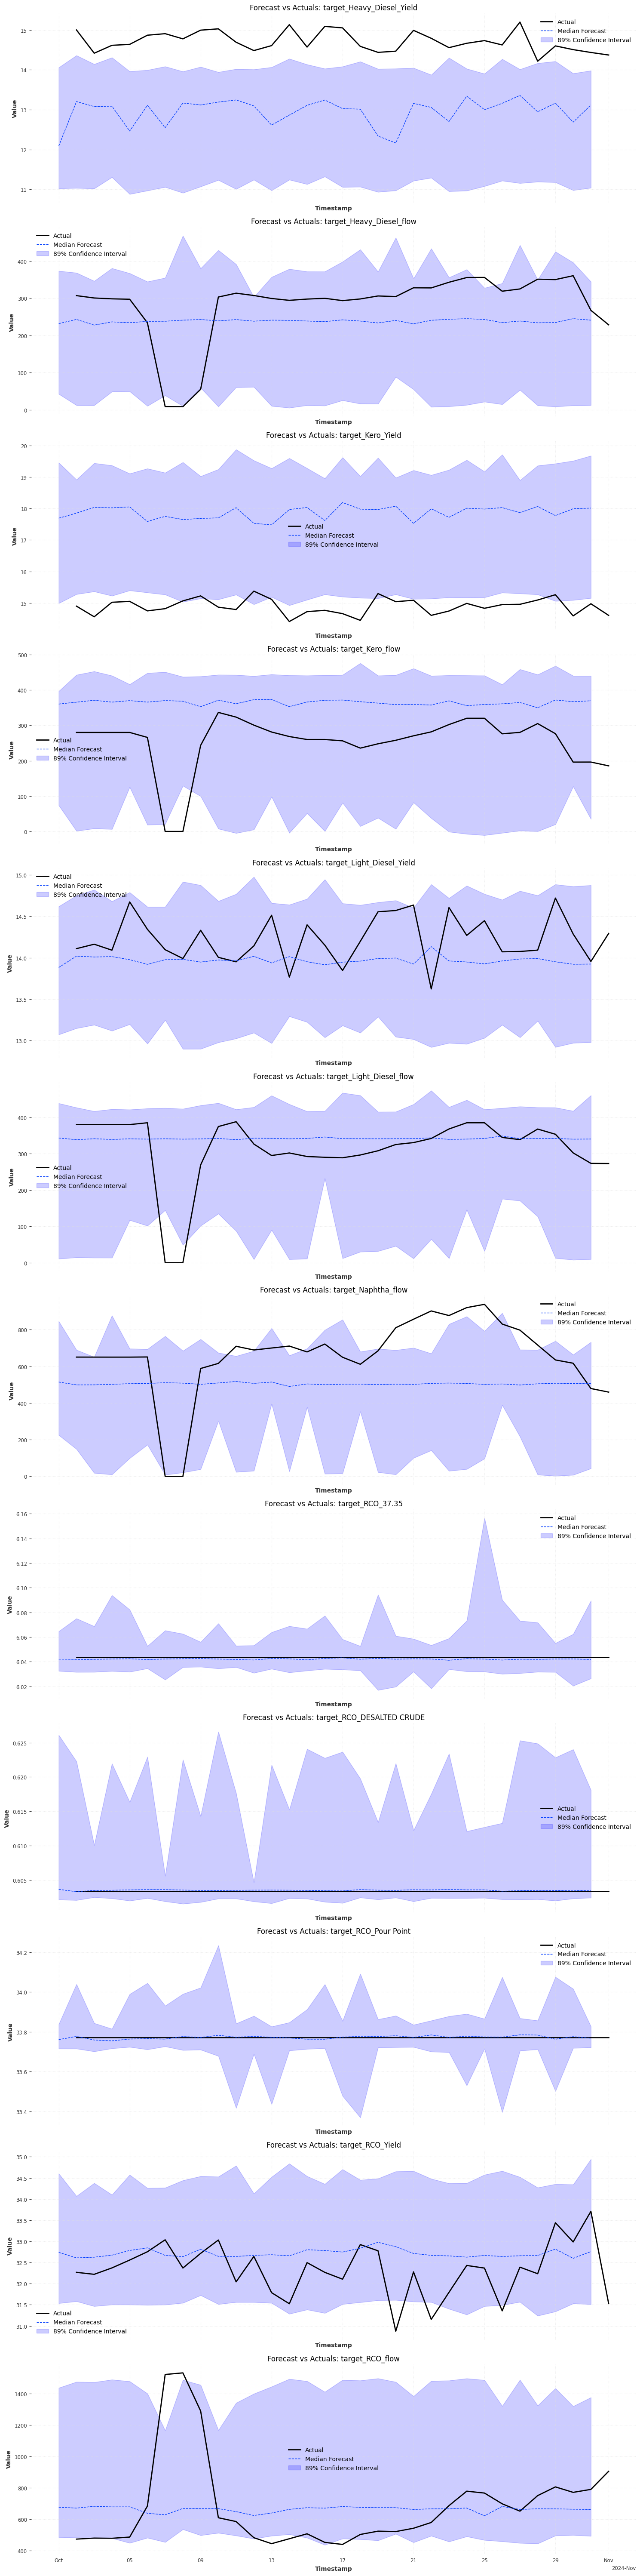

In [16]:
import matplotlib.pyplot as plt

print("--- Visualizing Predictions vs Actuals ---")

# Determine the number of steps predicted (should match predictions_inv length)
num_steps_predicted = len(predictions_inv)

# Slice the actual validation data to match the prediction length for plotting
actual_val_ts_slice = actual_val_ts[:num_steps_predicted]

# Check if lengths match now (they should after slicing)
if len(actual_val_ts_slice) != len(predictions_inv):
    print(f"Warning: Length mismatch persists after slicing. Actual slice: {len(actual_val_ts_slice)}, Prediction: {len(predictions_inv)}")
    # Adjust shorter one if needed, though slicing should handle this
    min_len = min(len(actual_val_ts_slice), len(predictions_inv))
    actual_val_ts_slice = actual_val_ts_slice[:min_len]
    predictions_inv = predictions_inv[:min_len]


# --- Create Plots ---
num_targets = len(target_cols)
fig, axes = plt.subplots(nrows=num_targets, ncols=1, figsize=(15, 5 * num_targets), sharex=True)

# Handle the case of a single target (axes is not an array)
if num_targets == 1:
    axes = [axes]

# Loop through each target variable
for i, target_name in enumerate(target_cols):
    ax = axes[i]

    # Find the matching component name in predictions_inv
    pred_component_name = None
    for col in predictions_inv.components:
        if col.startswith(target_name):
            pred_component_name = col
            break
    if pred_component_name is None:
         print(f"Warning: Could not find matching component for {target_name} in predictions_inv columns: {predictions_inv.components}. Skipping plot for this target.")
         continue

    # Plot Actual Data
    actual_val_ts_slice[target_name].plot(ax=ax, label="Actual", lw=2)

    # Plot Median Forecast
    predictions_inv[pred_component_name].plot(ax=ax, label="Median Forecast", lw=1, linestyle='--')


    # --- Optional: Plot Uncertainty Intervals (Requires predictions_scaled and target_scaler) ---
    if 'predictions_scaled' in locals() and 'target_scaler' in locals() and hasattr(predictions_scaled, 'quantile_timeseries'):
        try:
            # Define desired quantiles for the interval (e.g., 5% and 95% for 90% interval)
            lower_quantile = 0.05
            upper_quantile = 0.95

            # Extract scaled quantile timeseries
            lower_q_scaled = predictions_scaled.quantile_timeseries(quantile=lower_quantile)
            upper_q_scaled = predictions_scaled.quantile_timeseries(quantile=upper_quantile)

            # Inverse transform the scaled quantiles
            lower_q_inv = target_scaler.inverse_transform(lower_q_scaled)
            upper_q_inv = target_scaler.inverse_transform(upper_q_scaled)

            # Get the correct component names for the quantiles
            pred_lower_component_name = None
            pred_upper_component_name = None
            for col in lower_q_inv.components: # Assuming component names match between lower/upper
                if col.startswith(target_name):
                    pred_lower_component_name = col
                    # Construct the expected upper name based on the lower one (replace quantile value)
                    pred_upper_component_name = col.replace(f"_{lower_quantile}", f"_{upper_quantile}")
                    break

            if pred_lower_component_name and pred_upper_component_name and pred_upper_component_name in upper_q_inv.components:
                 # Plot the uncertainty interval using fill_between
                 ax.fill_between(
                     lower_q_inv.time_index, # X-axis (time)
                     lower_q_inv[pred_lower_component_name].values().flatten(), # Lower bound values
                     upper_q_inv[pred_upper_component_name].values().flatten(), # Upper bound values
                     color='blue',
                     alpha=0.2, # Transparency
                     label=f"{int((upper_quantile-lower_quantile)*100)}% Confidence Interval"
                 )
            else:
                 print(f"Warning: Could not find matching quantile components for {target_name}. Skipping interval plot.")

        except Exception as e:
            print(f"Could not plot uncertainty intervals for {target_name}: {e}")
    # --- End Optional Uncertainty Plot ---


    ax.set_title(f"Forecast vs Actuals: {target_name}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()